# **Modelo de Estimación del Precio de Viviendas**
## **Entendimiento del Problema y de los Datos**
Este dataset contiene información recolectada de precios y características de 142 mil viviendas en Colombia. La información se encuentra disponible públicamente en el repositorio Kaggle: https://www.kaggle.com/datasets/danieleduardofajardo/colombia-house-prediction

### Cargamos las librerías

In [ ]:
## Rscript -e "install.packages('tdplyr',repos=c('https://r-repo.teradata.com','https://cloud.r-project.org'))"
## install.packages('corrplot')

In [1]:
# Versión de R
R.Version()

$platform
[1] "x86_64-w64-mingw32"

$arch
[1] "x86_64"

$os
[1] "mingw32"

$system
[1] "x86_64, mingw32"

$status
[1] ""

$major
[1] "4"

$minor
[1] "1.3"

$year
[1] "2022"

$month
[1] "03"

$day
[1] "10"

$`svn rev`
[1] "81868"

$language
[1] "R"

$version.string
[1] "R version 4.1.3 (2022-03-10)"

$nickname
[1] "One Push-Up"

In [2]:
## Carga de Librerías
options(warn=-1)

LoadPackages <- function()
{library(dbplyr)
  library(tidyverse)
  library(lubridate)
  library(ggplot2)
  library(tdplyr)
  library(teradatasql)
  library(DBI)}

suppressPackageStartupMessages(LoadPackages())

options(val.install.location = "val")

### Creamos la conexión con Vantage

In [3]:
con <- td_create_context(host = "20.172.147.24", uid="pocuser", pwd="pocuser", dType = "native")
td_set_context(con)

![Slide](images/Diapositiva10.PNG)

<font color='red'/>

### Creamos el DataFrame y traemos la cabecera

In [4]:
tdPrecios <- tbl(con, dplyr::sql("select id, area, habitaciones, antiguedad_original, 
CASE WHEN banos is null then 0 else banos end as banos, 
CASE WHEN garajes is null then 0 else garajes end as garajes, 
CASE WHEN estrato is null then 0 else estrato end as estrato, SQRT(valor) as rvalor, 
SAMPLEID as sid FROM DW_DATA.Precio_Casas_Col 
WHERE area between 20 and 2000 and valor between 50000000 and 5000000000 
SAMPLE RANDOMIZED ALLOCATION 0.7, 0.3"))

In [5]:
## Primeros registros
head(tdPrecios)

# Source:   SQL [6 x 9]
# Database: Teradata
      id  area habitaciones antiguedad_original banos garajes estrato rvalor
   <int> <dbl>        <int> <chr>               <int>   <int>   <int>  <dbl>
1 131793   115            3 Entre 10 y 20 aÃ±os     3       2       0 25100.
2  52917   300            4 Entre 0 y 5 aÃ±os       5       4       6 43589.
3 126226   119            3 Entre 0 y 5 aÃ±os       4       3       4 24900.
4  19046    65            3 Entre 0 y 5 aÃ±os       2       1       3 16432.
5 140378   124            3 Entre 5 y 10 aÃ±os      3       2       5 24860.
6  55935   285            3 Entre 0 y 5 aÃ±os       4       4       6 64653.
# i 1 more variable: sid <int>

In [6]:
## Transformando el resultados anterior a un DataFrame de R
as.data.frame(head(tdPrecios))

id,area,habitaciones,antiguedad_original,banos,garajes,estrato,rvalor,sid
<int>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<dbl>,<int>
55935,285,3,Entre 0 y 5 aÃ±os,4,4,6,64652.92,2
3079,170,4,Entre 5 y 10 aÃ±os,5,2,5,27477.26,2
61502,65,3,Entre 0 y 5 aÃ±os,2,1,3,17029.39,1
131793,115,3,Entre 10 y 20 aÃ±os,3,2,0,25099.80,1
67069,135,3,Entre 0 y 5 aÃ±os,3,2,4,25884.36,2
120659,120,3,Entre 10 y 20 aÃ±os,3,2,4,20493.90,1


### Tamaño de la tabla

In [7]:
## Cantidad de Registros
td_nrow(tdPrecios)

integer64
[1] 143970

![Slide](images/Diapositiva6.PNG)

## **Explorando las Variables**

In [8]:
# Descriptivo de variables numéricas: Nos muestra las estadísticas descriptivas de las variables numéricas en nuestra tabla de datos. 
stats <- td_statistics_valib(data=tdPrecios,
                           columns=c("area","habitaciones","banos","garajes","estrato"),
                           stats.options="all",
                           extended.options="all")
as.data.frame(stats$result)

xdb,xtbl,xcol,xcnt,xmin,xmax,xmean,xstd,xskew,xkurt,...,xmax_5,xmax_4,xmax_3,xmax_2,xmax_1,xmaxcnt_5,xmaxcnt_4,xmaxcnt_3,xmaxcnt_2,xmaxcnt_1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
POCUSER,r__t__td_val_input_1696612304006511,banos,143970,0,52,2.581149,1.0345307,2.0161540,60.7685630,...,21,22,25,46,52,1,1,1,1,1
POCUSER,r__t__td_val_input_1696612304006511,area,143970,20,1998,114.416036,73.2648492,3.3245616,38.5500891,...,1955,1980,1987,1993,1998,1,1,2,4,1
POCUSER,r__t__td_val_input_1696612304006511,estrato,143970,0,7,4.545787,1.5001162,-1.2238701,1.5395359,...,3,4,5,6,7,18250,36236,29866,49897,2
POCUSER,r__t__td_val_input_1696612304006511,habitaciones,143961,0,86,2.605560,0.8642404,11.8873182,968.5076978,...,30,46,56,66,86,2,1,1,1,1
POCUSER,r__t__td_val_input_1696612304006511,garajes,143970,0,10,1.580545,0.8915045,0.4754337,0.9466321,...,5,6,7,8,10,90,40,1,2,6


In [9]:
# Histogramas: Nos muestra los descriptivos resultantes de agrupar en intervalos las variables numéricas de nuestra tabla de datos.
hist <- td_histogram_valib(data=tdPrecios, columns=c("area","habitaciones","banos","garajes","estrato"))
arrange(as.data.frame(hist$result),xcol,xbin)

xdb,xtbl,xcol,xbin,xbeg,xend,xcnt,xpct
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
POCUSER,r__t__td_val_input_1696612345082662,area,1,20.0,217.8,131799,9.154616e+01
POCUSER,r__t__td_val_input_1696612345082662,area,2,217.8,415.6,11483,7.975967e+00
POCUSER,r__t__td_val_input_1696612345082662,area,3,415.6,613.4,598,4.153643e-01
POCUSER,r__t__td_val_input_1696612345082662,area,4,613.4,811.2,60,4.167535e-02
POCUSER,r__t__td_val_input_1696612345082662,area,5,811.2,1009.0,11,7.640481e-03
POCUSER,r__t__td_val_input_1696612345082662,area,6,1009.0,1206.8,7,4.862124e-03
POCUSER,r__t__td_val_input_1696612345082662,area,7,1206.8,1404.6,1,6.945892e-04
POCUSER,r__t__td_val_input_1696612345082662,area,9,1602.4,1800.2,2,1.389178e-03
POCUSER,r__t__td_val_input_1696612345082662,area,10,1800.2,1998.0,9,6.251302e-03


### Distribución de Frecuencias por la Antiguedad

In [10]:
tdf <- td_frequency_valib(data=tdPrecios, columns="antiguedad_original")
head(tdf)

$result
# Source:   table<"POCUSER"."r__t__valib_td_frequency_valib1696612368053193"> [10 x 5]
# Database: Teradata
   xtbl                                xcol                xval       xcnt  xpct
   <chr>                               <chr>               <chr>     <dbl> <dbl>
 1 r__t__td_val_input_1696612367932996 antiguedad_original MÃ¡s de ~  2463  1.71
 2 r__t__td_val_input_1696612367932996 antiguedad_original 1 a 8 aÃ~ 10550  7.33
 3 r__t__td_val_input_1696612367932996 antiguedad_original Remodela~  2179  1.51
 4 r__t__td_val_input_1696612367932996 antiguedad_original Menos de~  2220  1.54
 5 r__t__td_val_input_1696612367932996 antiguedad_original Entre 0 ~ 34351 23.9 
 6 r__t__td_val_input_1696612367932996 antiguedad_original 16 a 30 ~  8828  6.13
 7 r__t__td_val_input_1696612367932996 antiguedad_original Entre 10~ 38429 26.7 
 8 r__t__td_val_input_1696612367932996 antiguedad_original Entre 5 ~ 24503 17.0 
 9 r__t__td_val_input_1696612367932996 antiguedad_original MÃ¡s de ~ 13465

In [11]:
## Convirtiendo el resultado en un DataFrame de R para poder realizar un gráfico
df <- as.data.frame(tdf$result)[c('xval','xcnt')]

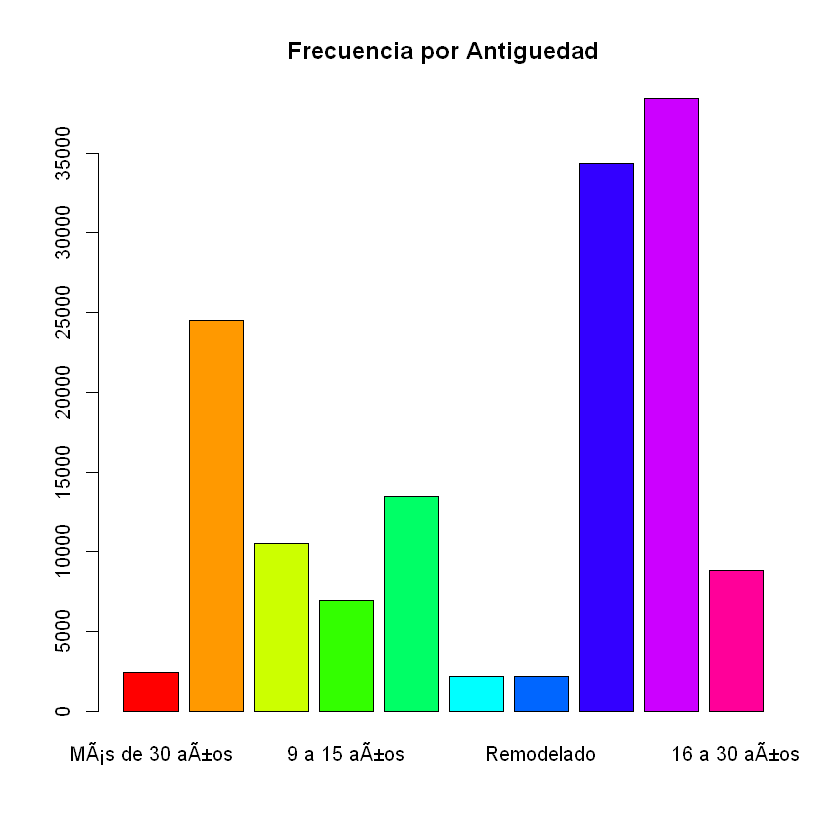

In [12]:
## Gráfica de Frecuencias
barplot(height = df$xcnt, names = df$xval, main = "Frecuencia por Antiguedad", col = rainbow(10))

### Matriz de Correlaciones para las variables numéricas

In [13]:
obj <- td_matrix_valib(data=tdPrecios, columns="allnumeric", exclude.columns = c("id", "sid"), type="COR")
obj$result %>% arrange(rownum)

# Source:     SQL [6 x 8]
# Database:   Teradata
# Ordered by: rownum
  rownum rowname       area habitaciones banos garajes  estrato rvalor
   <int> <chr>        <dbl>        <dbl> <dbl>   <dbl>    <dbl>  <dbl>
1      1 area         1          0.449   0.707   0.637  0.391    0.849
2      2 habitaciones 0.449      1       0.475   0.242 -0.00274  0.291
3      3 banos        0.707      0.475   1       0.633  0.395    0.718
4      4 garajes      0.637      0.242   0.633   1      0.472    0.737
5      5 estrato      0.391     -0.00274 0.395   0.472  1        0.522
6      6 rvalor       0.849      0.291   0.718   0.737  0.522    1    

In [14]:
## Transformando el resultado en una Matriz para poder graficar
mat <- as.matrix(as.data.frame(arrange(obj$result, rownum))[,3:8],rownames=TRUE)
mat

,area,habitaciones,banos,garajes,estrato,rvalor
1,1.0000000,0.448921174,0.7070129,0.6365838,0.391479335,0.8492533
2,0.4489212,1.000000000,0.4746244,0.2422131,-0.002738513,0.2906694
3,0.7070129,0.474624412,1.0000000,0.6326841,0.395472014,0.7179217
4,0.6365838,0.242213082,0.6326841,1.0000000,0.471567812,0.7369509
5,0.3914793,-0.002738513,0.3954720,0.4715678,1.000000000,0.5220129
6,0.8492533,0.290669387,0.7179217,0.7369509,0.522012880,1.0000000


corrplot 0.92 loaded



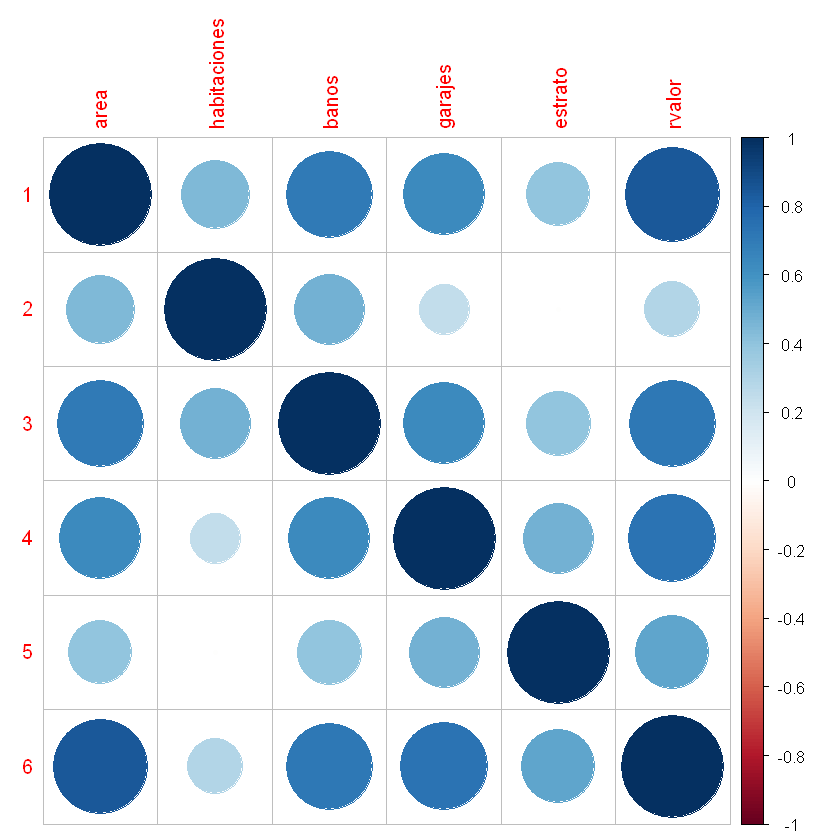

In [15]:
## Gráfica de la Matriz de Correlaciones, Mientras más grande y oscuro el círculo, más alta la correlación
library('corrplot')
corrplot(mat, method="circle")

### División de Muestras Train y Test

In [16]:
# Muestra de Entrenamiento
tbl_train <- filter(tdPrecios, sid == 1)

In [17]:
# Muestra de Test
tbl_test <- filter(tdPrecios, sid == 2)

In [18]:
# Comprobando que cada DataFrame de tdplyr está asociado a un query en la BD
show_query(tbl_train)

<SQL>
SELECT *
FROM (
select id, area, habitaciones, antiguedad_original, 
CASE WHEN banos is null then 0 else banos end as banos, 
CASE WHEN garajes is null then 0 else garajes end as garajes, 
CASE WHEN estrato is null then 0 else estrato end as estrato, SQRT(valor) as rvalor, 
SAMPLEID as sid FROM DW_DATA.Precio_Casas_Col 
WHERE area between 20 and 2000 and valor between 50000000 and 5000000000 
SAMPLE RANDOMIZED ALLOCATION 0.7, 0.3
) "q01"
WHERE ("sid" = 1.0)


<font color='red'/>

## **Entrenamiento del Modelo (In-Database)**

### Generación del Modelo de Estimación de Precios utilizando Regresión Lineal Múltiple con Selección de Variables Stepwise

In [19]:
tdModel <- td_lin_reg_valib(data=tbl_train,
                            columns='all',
                            exclude.columns=c('id','sid','antiguedad_original'),
                            stepwise='True',
                            response.column='rvalor')

In [20]:
## Parámetros del Modelo
head(tdModel$model,10)

# Source:   SQL [6 x 10]
# Database: Teradata
  `Column Name` `B Coefficient` `Standard Error` `T Statistic` `P-Value`   Lower
  <chr>                   <dbl>            <dbl>         <dbl>     <dbl>   <dbl>
1 (Constant)             7450.            58.2           128.          0  7335. 
2 area                     74.9            0.271         276.          0    74.3
3 banos                  1421.            19.4            73.2         0  1383. 
4 estrato                 772.            10.2            76.0         0   752. 
5 garajes                2524.            20.8           121.          0  2483. 
6 habitaciones          -1085.            17.2           -63.0         0 -1119. 
# i 4 more variables: Upper <dbl>, `Standard Coefficient` <dbl>,
#   `Incremental R-Squared` <dbl>,
#   `Squared Multiple Correlation Coefficient (1-Tolerance)` <dbl>

In [21]:
## Estadísticas de performance
print(tdModel$statistical.measures)

# Source:   table<"POCUSER"."r__t__valib_td_lin_reg_valib1696612494611627_rpt"> [1 x 18]
# Database: Teradata
    rid `Total Observations` `Total Sum of Squares` Multiple Correlation Coeff~1
  <int>                <dbl>                  <dbl>                        <dbl>
1     1               100779                9.02e12                        0.901
# i abbreviated name: 1: `Multiple Correlation Coefficient (R):`
# i 14 more variables:
#   `Squared Multiple Correlation Coefficient (1-Tolerance)` <dbl>,
#   `Adjusted R-Squared` <dbl>, `Standard Error of Estimate` <dbl>,
#   `Regression Sum of Squares` <dbl>, `Regression Degrees of Freedom` <dbl>,
#   `Regression Mean-Square` <dbl>, `Regression F Ratio` <dbl>,
#   `Regression P-Value` <dbl>, `Residual Sum of Squares` <dbl>, ...


In [22]:
## Almacenando los parámetros del Modelo en la BD
copy_to(con, tdModel$model, name = "Modelo_Precios_Casas_R")

## **Evaluación del Modelo**
### Calculando las métricas de diagnóstico del Modelo

In [23]:
tdEval <- td_lin_reg_evaluator_valib(data=tbl_test, model=tdModel$model, index.columns='id')

In [24]:
## Estadísticas de performance
as.data.frame(tdEval$result)

Minimum Absolute Error,Maxmum Absolute Error,Average Absolute Error,Standard Error of Estimate
<dbl>,<dbl>,<dbl>,<dbl>
0.03557262,140134.5,2538.317,3896.365


<font color='red'/>

## **Depliegue del Modelo (In-Database)**

### Implementando el modelo para estimar el precio de otras viviendas

In [25]:
tdScore <- td_lin_reg_predict_valib(data=tbl_test, model=tdModel$model, response.column="rvalor_estim", index.columns='id')

In [26]:
head(tdScore)

$result
# Source:   table<"POCUSER"."r__t__valib_td_lin_reg_predict_valib1696612612054939"> [?? x 3]
# Database: Teradata
       id rvalor_estim Residual
    <int>        <dbl>    <dbl>
 1  84361       31196.    4860.
 2  73084       10451.     729.
 3  14253       17151.    2214.
 4 112848       30759.    1644.
 5   9746       37573.    7036.
 6 133953       24824.   -2688.
 7  29118       34502.   -4502.
 8  45840       60590.   -6739.
 9  65845       20888.   -4764.
10  64173       19008.     740.
# i more rows


In [27]:
## Calculamos el valor total del Precio de la Vivienda, ya que para desarrollar el modelo extrajimos la raíz como respuesta
derive_1 <- tdDerive(formula='x*x', columns='rvalor_estim', out.column='valor_estim')

In [28]:
## Aplicando la Transformación anterior
FinalScore <- td_transform_valib(data=tdScore$result, derive=derive_1, key.columns='id', index.columns='id')

In [29]:
head(FinalScore$result)

# Source:   SQL [6 x 2]
# Database: Teradata
      id valor_estim
   <int>       <dbl>
1  19902 1464453191.
2  38336  931498360.
3 129345  398273897.
4  87909  196433496.
5  74981  325264105.
6  61971  296240931.

In [30]:
## Llevamos la información a una Tabla de resultados llamada Precio_Score_R
copy_to(con, FinalScore$result, name = "Precio_Score_R")

### Limpiando las tablas creadas

In [31]:
try(db_drop_table(con, "Modelo_Precios_Casas_R"), silent = TRUE)

[1] 25

In [32]:
try(db_drop_table(con, "Precio_Score_R"), silent = TRUE)

[1] 17

In [33]:
# Finaliza todo y depura las tablas temporales creadas
td_remove_context()

Copyright 2023. Elaborado por Luis Cajachahua bajo licencia MIT